<a href="https://colab.research.google.com/github/simulate111/Introduction-to-Human-Language-Technology/blob/main/Exercise%20task%206%3A%20hyperparameters_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Before we start running our own Python code, install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package primarily on top of torch, we need to reinstall it with the [torch] configuration (might take a substantial amount of time)
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets
* evaluate is a library of performance metrics (like accuracy etc)

**You will likely need to do a Runtime/Restart session for everything to work after the installation.**

In [1]:
!pip3 install -q datasets evaluate
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

---

# Get and prepare data

*   Let us work with the IMDB dataset of movie review sentiment
*   25,000 positive reviews
*   25,000 negative reviews
*   50,000 unlabeled reviews (which we discard for the time being)


In [2]:
from pprint import pprint #pprint => pretty-print, I use it occassionally throughout the notebook
import datasets
import torch
dset=datasets.load_dataset("imdb")
pprint(dset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:
dset=dset.shuffle() #This is never a bad idea, datasets may have ordering to them, which is not what we want
del dset["unsupervised"] #Delete the unlabeled part of the dataset, we don't need it for anything

In [4]:
pprint(dset['train'][0]['text'])
print(dset['train'][0]['label'])

('I know I know it was a good ending but sincerely it was awesome. I love when '
 'a movie ends on a terrific dark nature but this time I was impressed with '
 'Darth Vader turning against the Emperor I really stayed astonished. The '
 'anguishing sequence in that film was when Luke is tortured and defeated by '
 'the Emperor/Darth Sidious. He is about to be destroyed when Darth Vader, '
 'Dark Lord of the Sith, eliminates his dark master. A nice sacrifice. The '
 'cinematography of this film is impressive. I was surprised with all the '
 'vessels of the Rebel Battle ships and all Imperial War Ships and Super Star '
 'Destroyers. I loved the new race they brought on screen the Mon Calomari, '
 "the ewoks, the sullesteian (Lando's co pilot) and many more... Most of my "
 'favorite scenes are in that film:1-When Vader destroys the Emperor and is '
 'fatally wounded. 2- When Luke sees the spirits of Obi-Wan and Yoda and then '
 'it shows up Anakin Skywalker (Sebastian Shaw)(the greatest s

## Tokenize and map vocabulary
         
*   We need to achieve two complementary tasks
*   **Tokenize** split the text into units which can be interpreted as features (words in this case)
*   **Map vocabulary** build the feature vector for each example
*   Since this is NLP, here it means listing the non-zero elements of the feature vector, or in other words the indices of the vocabulary items
* Since we work with the bag of words (BoW) representation, these do not need to be (and are not) in the order in which they appear in the text
* These indices then refer to the rows in the embedding matrix
*   A traditional and well-tested way it to use sklearn's feature extraction package
*   CountVectorizer is most likely what we want in here, because we only want the ids, nothing else
* But for other NLP work the TfidfVectorizer is also very handy



In [5]:
import sklearn.feature_extraction

# max_features means the size of the vocabulary
# which means max_features most-common words
vectorizer=sklearn.feature_extraction.text.CountVectorizer(binary=True,max_features=20000)

texts=[ex["text"] for ex in dset["train"]] #get a list of all texts from the training data
vectorizer.fit(texts) #"Trains" the vectorizer, i.e. builds its vocabulary


CountVectorizer(binary=True, max_features=20000)

# Building the feature vectors

* This is super-easy with the vectorizer
* It produces a sparse matrix of the non-zero elements

In [6]:
def vectorize_example(ex):
    vectorized=vectorizer.transform([ex["text"]]) # [...] because the vectorizer expects a list/iterable over inputs, not one input
    non_zero_features=vectorized.nonzero()[1] #.nonzero gives a pair of (rows,columns), we want the columns
    non_zero_features+=1 #feature index 0 will have a special meaning
                         # so let us not produce it by adding +1 to everything
    return {"input_ids":non_zero_features}

vectorized=vectorize_example(dset["train"][0])

In [7]:
print(vectorized)

{'input_ids': array([   10,   309,   606,   727,   866,   887,  1115,  1207,  1287,
        1460,  1687,  1702,  1880,  1901,  1937,  2295,  2455,  2604,
        2625,  3282,  3467,  3583,  4298,  4578,  4592,  4647,  4731,
        4979,  4982,  5647,  5917,  6000,  6052,  6056,  6060,  6342,
        6701,  6722,  6878,  7801,  7934,  8012,  8350,  8592,  9023,
        9058,  9066,  9085,  9602,  9630,  9648, 10090, 10209, 10359,
       10475, 10662, 10696, 10698, 10747, 10970, 11076, 11261, 11610,
       11681, 11721, 11762, 11857, 11954, 12060, 12079, 12285, 12363,
       12437, 13099, 13237, 13527, 13676, 14149, 14349, 14363, 15309,
       15502, 15505, 15589, 15603, 15653, 15697, 15778, 15916, 15975,
       16049, 16163, 16202, 16267, 16297, 16622, 16736, 16902, 16952,
       17102, 17375, 17444, 17845, 17893, 17897, 17917, 17944, 17968,
       18074, 18115, 18202, 18525, 18922, 18995, 19114, 19343, 19359,
       19394, 19398, 19509, 19549, 19712, 19810, 19920], dtype=int32)}


In [8]:
# We can map back to vocabulary and check that everything works
# vectorizer.vocabulary_ is a dictionary {key:word, value:idx}

idx2word=dict((i,w) for (w,i) in vectorizer.vocabulary_.items()) #inverse the vocab dictionary
words=[]
for idx in vectorized["input_ids"]:
    words.append(idx2word[idx-1]) ## It is easy to forgot we moved all by +1
pprint(", ".join(words)) #This is now the bag of words representation of the document

('10, about, against, all, anakin, and, are, as, astonished, awesome, battle, '
 'be, best, between, bikini, br, brought, but, by, cinematography, co, combat, '
 'crime, dark, darth, death, defeated, destroyed, destroys, duel, eliminates, '
 'emperor, ending, endor, ends, ewoks, fatally, favorite, film, good, '
 'greatest, ground, he, his, imperial, impressed, impressive, in, is, it, '
 'jabba, know, lando, leia, like, lord, love, loved, luke, many, master, '
 'memorable, mon, more, most, movie, my, nature, new, nice, obi, of, on, '
 'personally, pilot, post, presenting, race, really, rebel, sacrifice, scene, '
 'scenes, screen, script, sebastian, sees, sequence, shaw, ships, shows, '
 'sincerely, sith, skywalker, slave, space, spirits, star, stayed, strangling, '
 'super, surprised, terrific, that, the, then, they, this, time, to, tortured, '
 'turning, up, vader, vessels, wan, war, wars, was, well, when, with, wounded, '
 'yoda')


# Tokenizing / vectorizing the whole dataset

* The datasets library allows us to efficiently map() a function across the whole dataset
* Can run in parallel

**Note**: confusingly, and unlike the Python`map` function, [`Dataset.map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) function _updates_ its argument dataset, keeping existing values. Here, the call adds the values returned by the function call (here `input_ids`) to each example while also keeping the original `text` and `label` values.


In [9]:
# Apply the tokenizer to the whole dataset using .map()
dset_tokenized = dset.map(vectorize_example,num_proc=4)
pprint(dset_tokenized["train"][0])

Map (num_proc=4):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/25000 [00:00<?, ? examples/s]

{'input_ids': [10,
               309,
               606,
               727,
               866,
               887,
               1115,
               1207,
               1287,
               1460,
               1687,
               1702,
               1880,
               1901,
               1937,
               2295,
               2455,
               2604,
               2625,
               3282,
               3467,
               3583,
               4298,
               4578,
               4592,
               4647,
               4731,
               4979,
               4982,
               5647,
               5917,
               6000,
               6052,
               6056,
               6060,
               6342,
               6701,
               6722,
               6878,
               7801,
               7934,
               8012,
               8350,
               8592,
               9023,
               9058,
               9066,
               9085,

## Input encoding for MLP

* Our `input_ids` are an array containing the indices of the tokens found in the text
* This corresponds to the indices into the row of the embedding matrix in the model
* That seems to be exactly what we need!


# Batching and padding

* When working with neural networks, one rarely trains one example at a time
* Instead, processing always happens a batch at a time
* This has two important reasons:
  1. No batching is too slow (GPU parallelization cannot kick in across examples)
  2. The gradients are averaged across the whole batch and applied only once, i.e. batching acts as a regularizer and improves the stability of the training


# Padding and Collation (forming a batch)

## Padding:

* In order to build a batch as a 2D array of (example, seq), we need to fit together examples of different length
* Solution: pad the shorter examples with zeroes to the length of the longest example in the batch
* Make sure that zero is understood as padding value rather than a (hypothetical) feature with index 0
* This is best shown by example, it is in the end easier than it may sound

## Collation:

* Much like examples are dictionaries with the data, also batches are dictionaries with the data
* The only difference is that in a batch, all data tensors have one extra dimension, that's all there is to it

## Collator function:

* Padding and collation is taken care of by a single function in the HF libraries
* It receives a list of examples, and returns a ready batch
* The surrounding library code takes care of forming these lists
* Let's try to implement one below

In [10]:
# 1) I need to define it here, will explain below
# 2) I show here a very straightforward implementation of padding and collation
# 3) Normally, one would use transformers.DataCollatorWithPadding but that assumes
#    a particular tokenizer, to which it outsources much of the work, and we do not
#    have it
def collator(list_of_examples):
    #this is easy, labels are made into a single tensor
    batch={"labels":torch.tensor(list(ex["label"] for ex in list_of_examples))}
    #the worse bit is now to pad the examples, as they are of different length
    tensors=[]
    max_len=max(len(example["input_ids"]) for example in list_of_examples) #this is the longest example in the batch
    #everything needs to be padded to fit in length the longest example
    #(so we can build a single tensor out of it)
    for example in list_of_examples:
        ids=torch.tensor(example["input_ids"]) #pick the input ids
        # pad(what,(from_left, from_right)) <- this is how we call the stock pad function
        padded=torch.nn.functional.pad(ids,(0,max_len-ids.shape[0])) #pad by max - current length, pads with zero by default
        tensors.append(padded) #accumulated the padded ids
    batch["input_ids"]=torch.vstack(tensors) #now that we have all of them the same length, a simple vstack() stacks them up
    return batch #...and that's all there is to it



#Build a batch from 2 examples, with padding
batch=collator([dset_tokenized["train"][2],dset_tokenized["train"][7]])
print("Shape of labels:",batch["labels"].shape)
print("Shape of input_ids:",batch["input_ids"].shape)
pprint(batch["labels"])
pprint(batch["input_ids"])

Shape of labels: torch.Size([2])
Shape of input_ids: torch.Size([2, 92])
tensor([0, 1])
tensor([[   10,   168,   612,   727,   806,   887,  1207,  1300,  2295,  2501,
          2604,  2711,  3128,  3267,  3629,  4541,  5172,  5395,  5755,  6302,
          6315,  6320,  6586,  6663,  6734,  7127,  7346,  7388,  7449,  7627,
          7692,  7801,  8289,  8322,  8350,  8378,  8533,  8553,  8780,  9085,
          9249,  9602,  9630,  9638, 10008, 10065, 10258, 10263, 10708, 11391,
         11409, 11681, 11762, 11776, 11869, 12134, 12363, 12437, 12527, 12564,
         12627, 13028, 13268, 13805, 14037, 14087, 14312, 14406, 15215, 15400,
         15416, 15544, 16020, 16464, 16478, 16818, 16938, 17893, 17897, 17900,
         17929, 17968, 18115, 18383, 18965, 19107, 19112, 19414, 19420, 19614,
         19785, 19927],
        [  727,   793,   887,  1115,  1764,  1900,  1925,  5736,  6100,  7287,
          7388,  7675,  7857,  8602,  9602,  9630, 10738, 11762, 11833, 12055,
         12257, 123

# Build the MLP model

* Now that all of our data is in shape, we can build the model
* That is luckily quite easy in this case

The model class in its simplest form has `__init__()` which instantiates the layers and `forward()` which implements the actual computation. For more information on these, please see the [PyTorch turorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).

In [11]:
import torch
import transformers

# A model wants a config, I can simply inherit from the base
# class for pretrained configs
class MLPConfig(transformers.PretrainedConfig):
    pass

# This is the model
class MLP(transformers.PreTrainedModel):

    config_class=MLPConfig

    # In the initialization method, one instantiates the layers
    # these will be, for the most part the trained parameters of the model
    def __init__(self,config):
        super().__init__(config)
        self.vocab_size=config.vocab_size #embedding matrix row count
        # Build and initialize embedding of vocab size +1 x hidden size (+1 because of the padding index 0!)
        self.embedding=torch.nn.Embedding(num_embeddings=self.vocab_size+1,embedding_dim=config.hidden_size,padding_idx=0)
        # Normally you would not initialize these yourself, but I have my reasons here ;)
        torch.nn.init.uniform_(self.embedding.weight.data,-0.001,0.001) #initialize the embeddings with small random values
        # Note! This function is relatively clever and keeps the embedding for 0, the padding, pure zeros
        # This takes care of the lower half of the network, now the upper half
        # Output layer: hidden size x output size
        self.output=torch.nn.Linear(in_features=config.hidden_size,out_features=config.nlabels)
        # Now we have the parameters of the model


    # The computation of the model is put into the forward() function
    # it receives a batch of data and optionally the correct `labels`
    #
    # If given `labels` it returns (loss,output)
    # if not, then it returns (output,)
    def forward(self,input_ids,labels=None):
        #1) sum up the embeddings of the items
        embedded=self.embedding(input_ids) #(batch,ids)->(batch,ids,embedding_dim)
        # Since the Embedding keeps the first row of the matrix pure zeros, we don't need to worry about the padding
        # so next we sum the embeddings across the word dimension
        # (batch,ids,embedding_dim) -> (batch,embedding_dim)
        embedded_summed=torch.sum(embedded,dim=1)

        #2) apply non-linearity
        # (batch,embedding_dim) -> (batch,embedding_dim)
        projected=torch.tanh(embedded_summed) #Note how non-linearity is applied here and not when configuring the layer in __init__()

        #3) and now apply the upper, output layer of the network
        # (batch,embedding_dim) -> (batch, num_of_classes i.e. 2 in our case)
        logits=self.output(projected)

        # ...and that's all there is to it!

        #print("input_ids.shape",input_ids.shape)
        #print("embedded.shape",embedded.shape)
        #print("embedded_summed.shape",embedded_summed.shape)
        #print("projected.shape",projected.shape)
        #print("logits.shape",logits.shape)

        # If we have labels, we ought to calculate the loss
        if labels is not None:
            loss=torch.nn.CrossEntropyLoss() #This loss is meant for classification, so let's use it
            # You run it as loss(model_output,correct_labels)
            return (loss(logits,labels),logits)
        else:
            # No labels, so just return the logits
            return (logits,)



In [12]:
# Configure the model:
#   these parameters are used in the model's __init__()
mlp_config=MLPConfig(vocab_size=len(vectorizer.vocabulary_),hidden_size=20,nlabels=2)

# And now we can instantiate it
mlp=MLP(mlp_config)

#we can make a little test with a fake batch formed by the two first example
fake_batch=collator([dset_tokenized["train"][0],dset_tokenized["train"][1]])
mlp(**fake_batch) #** expands input_ids and labels as parameters of the call

(tensor(0.6995, grad_fn=<NllLossBackward0>),
 tensor([[-0.0392,  0.2042],
         [-0.0574,  0.1825]], grad_fn=<AddmmBackward0>))

# Train the model

We will use the Hugging Face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class for training

* Loads of arguments that control the training
* Configurable metrics to evaluate performance
* Data collator builds the batches
* Early stopping callback stops when eval loss no longer improves
* Model load/save
* Excellent foundation for later deep learning course
  

First, let's create a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/trainer#transformers.TrainingArguments) object to specify hyperparameters and various other settings for training.

Printing this simple dataclass object will show not only the values we set, but also the defaults for all other arguments. Don't worry if you don't understand what all of these do! Many are not relevant to us here, and you can find the details in [`Trainer` documentation](https://huggingface.co/docs/transformers/main_classes/trainer) if you are interested.

In [13]:
# Set training arguments
# their names are mostly self-explanatory

#add two loops to go over various learning rates and batch sizes
####################################################
def training_arguments(learning_rate=1e-5, batch_size=128):
  #######################################################################################
  trainer_args = transformers.TrainingArguments(
      "mlp_checkpoints", #save checkpoints here
      evaluation_strategy="steps",
      logging_strategy="steps",
      eval_steps=500,
      logging_steps=500,

      ###########################################################################################
      #Explore various learning rates
      learning_rate=learning_rate, #1e-5, #learning rate of the gradient descent
      ##########################################################################################

      max_steps=20000,
      load_best_model_at_end=True,
      ####################################################################################
      #Explore various batch sizes
      per_device_train_batch_size=batch_size#128
      #################################################################################
  )

  pprint(trainer_args)
  return trainer_args

Next, let's create a metric for evaluating performance during and after training. We can use the convenience function [`load_metric`](https://huggingface.co/docs/datasets/about_metrics) to load one of many pre-made metrics and wrap this for use by the trainer.

As the task is simple binary classification and our data is even 50:50 balanced, we can comfortably use the basic `accuracy` metric, defined as the proportion of correctly predicted labels out of all labels.

In [14]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = np.argmax(outputs, axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)

We can then create the `Trainer` and train the model by invoking the [`Trainer.train`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.train) function.

In addition to the model, the settings passed in through the `TrainingArguments` object created above (`trainer_args`), the data, and the metric defined above, we create and pass the following to the `Trainer`:

* [data collator](https://huggingface.co/docs/transformers/main_classes/data_collator): groups input into batches
* [`EarlyStoppingCallback`](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback): stops training when performance stops improving

In [15]:
# Make a new model
mlp = MLP(mlp_config)


# Argument gives the number of steps of patience before early stopping
# i.e. training is stopped when the evaluation loss fails to improve
# certain number of times
early_stopping = transformers.EarlyStoppingCallback(5)

def trainers(trainer_args):
  trainer = transformers.Trainer(
      model=mlp,
      args=trainer_args,
      train_dataset=dset_tokenized["train"],
      eval_dataset=dset_tokenized["test"].select(range(1000)), #make a smaller subset to evaluate on
      compute_metrics=compute_accuracy,
      data_collator=collator,
      callbacks=[early_stopping]
  )

  # FINALLY!
  trainer.train()
  return trainer

We can then evaluate the trained model on a given dataset (here our test subset) by calling [`Trainer.evaluate`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.evaluate):

In [16]:
def evaluations(trainer):
    eval_results = trainer.evaluate(dset_tokenized["test"])

    print(eval_results)
    return eval_results

# Save the model for later use

* You can save it with `trainer.save_model()`
* You can load it with `MLP.from_pretrained()`


In [17]:
def save_model(name="mlp-imdb"):
  trainer.save_model(name)

# Check save/load

In [18]:
#mlp2=MLP.from_pretrained("mlp-imdb")

In [19]:
'''
trainer = transformers.Trainer(
    model=mlp2,
    args=trainer_args,
    train_dataset=dset_tokenized["train"],
    eval_dataset=dset_tokenized["test"],
    compute_metrics=compute_accuracy,
    data_collator=collator,
    callbacks=[early_stopping]
)
'''

'\ntrainer = transformers.Trainer(\n    model=mlp2,\n    args=trainer_args,\n    train_dataset=dset_tokenized["train"],\n    eval_dataset=dset_tokenized["test"],\n    compute_metrics=compute_accuracy,\n    data_collator=collator,\n    callbacks=[early_stopping]\n)\n'

In [20]:
'''
eval_results = trainer.evaluate(dset_tokenized["test"])
print(eval_results)
print('Accuracy:', eval_results['eval_accuracy'])
'''

'\neval_results = trainer.evaluate(dset_tokenized["test"])\nprint(eval_results)\nprint(\'Accuracy:\', eval_results[\'eval_accuracy\'])\n'

# Extra time left?

* Read through the TrainingArguments documentation, try to understand at least some parts of it https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments
* Read through Torch tensor operations, try to understand at least some parts of it: https://pytorch.org/docs/stable/tensors.html
* Run the model with different parameters (hidden layer width, learning rate, etc), how much do the results change?


# What has the model learned?

* The embeddings should have some meaning to them
* Similar features should have similar embeddings

In [21]:
# Grab the embedding matrix out of the trained model
# and drop the first row (padding 0)
# then we can treat the embeddings as vectors
# and maybe compare them to each other
# ha ha this below took some googling
weights=mlp.embedding.weight.detach().cpu().numpy()
weights=weights[1:,:]

In [22]:
qry_idx=vectorizer.vocabulary_["great"] #embedding of "great"

#calculate the distance of the "lousy" embedding to all other embeddings
distance_to_qry=sklearn.metrics.pairwise.euclidean_distances(weights[qry_idx:qry_idx+1,:],weights)
nearest_neighbors=np.argsort(distance_to_qry) #indices of words nearest to "lousy"
for nearest in nearest_neighbors[0,:20]:
    print(idx2word[nearest])
# This works great!

great
insights
firth
trepidation
pressburger
headaches
cults
aesthetics
advances
statues
richards
connolly
dummy
innumerable
steaming
abe
nominees
scully
unmarried
clicking


* The embeddings indeed seem to reflect the task
* There is a meaning to them

# Feature weights

*   A typical "old-school" way to approach the classification would be a simple linear model, like LinearSVM
*   Under such model, each feature (word) would have a single one weight
*   And the classification would simply be based on the sum of these weights
*   In this context of this task, "positive" words would get a high weight, "negative" words would get a low weight
*   It is in fact quite easy to reconfigure the MLP model to work more or less like this and this effect can be replicated
*   I will leave that as an exercise for you



In [23]:
import time

learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
batch_sizes = [10, 20, 40, 64, 128]
results = []

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        result_entry={}
        trainer_arg = training_arguments(learning_rate, batch_size)

        start_time = time.time()

        trainer = trainers(trainer_arg)
        eval_results = evaluations(trainer)

        end_time = time.time()
        training_time = end_time - start_time

        save_model(f'lr={learning_rate}_bs={batch_size}')

        result_entry = {
            "Learning Rate": learning_rate,
            "Batch Size": batch_size,
            "Epoch": eval_results["epoch"],
            "Validation Loss": eval_results["eval_loss"],
            "Accuracy": eval_results["eval_accuracy"],
            "Training Time": training_time}

        results.append(result_entry)

TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_l

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.685800,0.679498,0.641000
1000,0.671700,0.664758,0.762000
1500,0.656800,0.650007,0.783000
2000,0.639600,0.634047,0.812000
2500,0.622900,0.618151,0.815000
3000,0.602600,0.602107,0.826000
3500,0.589200,0.587368,0.832000
4000,0.569300,0.572791,0.833000
4500,0.558400,0.559095,0.837000
5000,0.539500,0.546137,0.842000


{'eval_loss': 0.4030337929725647, 'eval_accuracy': 0.86108, 'eval_runtime': 9.8633, 'eval_samples_per_second': 2534.645, 'eval_steps_per_second': 316.831, 'epoch': 8.0}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.364300,0.393283,0.865000
1000,0.359200,0.384246,0.865000
1500,0.346200,0.375735,0.864000
2000,0.336900,0.368328,0.864000
2500,0.331100,0.362025,0.865000
3000,0.317400,0.356010,0.867000
3500,0.318600,0.350019,0.866000
4000,0.301100,0.344494,0.869000
4500,0.301100,0.339877,0.870000
5000,0.297100,0.335927,0.868000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.29519370198249817, 'eval_accuracy': 0.88512, 'eval_runtime': 8.451, 'eval_samples_per_second': 2958.241, 'eval_steps_per_second': 369.78, 'epoch': 16.0}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.227700,0.292309,0.877000
1000,0.224100,0.290009,0.879000
1500,0.219400,0.288479,0.878000
2000,0.215000,0.286177,0.878000
2500,0.213600,0.284813,0.879000
3000,0.207400,0.283370,0.880000
3500,0.202700,0.282311,0.882000
4000,0.200700,0.281086,0.881000
4500,0.197100,0.280156,0.882000
5000,0.195100,0.279480,0.882000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.27641013264656067, 'eval_accuracy': 0.88784, 'eval_runtime': 9.4411, 'eval_samples_per_second': 2648.002, 'eval_steps_per_second': 331.0, 'epoch': 30.4}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.156100,0.274600,0.883000
1000,0.152900,0.275115,0.888000
1500,0.150700,0.274932,0.886000
2000,0.146700,0.275526,0.884000
2500,0.143900,0.275900,0.884000
3000,0.140700,0.276231,0.883000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.2763533294200897, 'eval_accuracy': 0.88804, 'eval_runtime': 9.2122, 'eval_samples_per_second': 2713.794, 'eval_steps_per_second': 339.224, 'epoch': 7.67}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.152300,0.275456,0.884000
1000,0.148300,0.275613,0.882000
1500,0.143700,0.275942,0.881000
2000,0.141300,0.276780,0.881000
2500,0.136300,0.277419,0.881000
3000,0.133700,0.278259,0.880000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.2795080542564392, 'eval_accuracy': 0.88512, 'eval_runtime': 9.2483, 'eval_samples_per_second': 2703.206, 'eval_steps_per_second': 337.901, 'epoch': 15.31}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.147100,0.296201,0.880000
1000,0.148300,0.289137,0.883000
1500,0.151300,0.304215,0.881000
2000,0.153500,0.298091,0.884000
2500,0.162500,0.304677,0.881000
3000,0.108800,0.323979,0.884000
3500,0.120500,0.320274,0.877000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.2861112058162689, 'eval_accuracy': 0.88776, 'eval_runtime': 8.132, 'eval_samples_per_second': 3074.289, 'eval_steps_per_second': 384.286, 'epoch': 1.4}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
f

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.107700,0.300474,0.884000
1000,0.157700,0.298987,0.874000
1500,0.133200,0.317756,0.883000
2000,0.108000,0.318838,0.877000
2500,0.115000,0.324064,0.874000
3000,0.084800,0.339481,0.874000
3500,0.092200,0.352604,0.872000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.3054540753364563, 'eval_accuracy': 0.88388, 'eval_runtime': 8.7208, 'eval_samples_per_second': 2866.717, 'eval_steps_per_second': 358.34, 'epoch': 2.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
f

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.103600,0.313025,0.875000
1000,0.113400,0.322773,0.877000
1500,0.089400,0.336822,0.877000
2000,0.077300,0.353686,0.876000
2500,0.068600,0.373540,0.870000
3000,0.055500,0.393370,0.866000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3276379704475403, 'eval_accuracy': 0.87848, 'eval_runtime': 8.8975, 'eval_samples_per_second': 2809.779, 'eval_steps_per_second': 351.222, 'epoch': 4.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.101000,0.326993,0.874000
1000,0.082900,0.345774,0.874000
1500,0.068900,0.364008,0.870000
2000,0.055900,0.388385,0.868000
2500,0.045600,0.412274,0.868000
3000,0.038800,0.435920,0.862000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3391090929508209, 'eval_accuracy': 0.87636, 'eval_runtime': 8.9243, 'eval_samples_per_second': 2801.355, 'eval_steps_per_second': 350.169, 'epoch': 7.67}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.077900,0.353470,0.874000
1000,0.058600,0.385066,0.869000
1500,0.044400,0.416025,0.864000
2000,0.034300,0.449327,0.863000
2500,0.026200,0.478594,0.857000
3000,0.020700,0.513276,0.856000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3643386662006378, 'eval_accuracy': 0.87252, 'eval_runtime': 8.705, 'eval_samples_per_second': 2871.92, 'eval_steps_per_second': 358.99, 'epoch': 15.31}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
f

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.151700,0.639105,0.831000
1000,0.241400,0.462883,0.860000
1500,0.241000,0.437093,0.851000
2000,0.261300,0.334325,0.853000
2500,0.247600,0.333264,0.868000
3000,0.085300,0.499042,0.862000
3500,0.122800,0.484374,0.858000
4000,0.119100,0.487509,0.864000
4500,0.133000,0.479051,0.851000
5000,0.144600,0.510406,0.853000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.36983034014701843, 'eval_accuracy': 0.85592, 'eval_runtime': 8.0118, 'eval_samples_per_second': 3120.399, 'eval_steps_per_second': 390.05, 'epoch': 2.0}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.116400,0.474579,0.858000
1000,0.112300,0.392800,0.858000
1500,0.082200,0.551155,0.854000
2000,0.057100,0.570780,0.849000
2500,0.074800,0.567507,0.852000
3000,0.025100,0.678641,0.849000
3500,0.032600,0.746273,0.845000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.42514070868492126, 'eval_accuracy': 0.85352, 'eval_runtime': 7.8827, 'eval_samples_per_second': 3171.503, 'eval_steps_per_second': 396.438, 'epoch': 2.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.052300,0.522038,0.856000
1000,0.066700,0.619676,0.847000
1500,0.031800,0.723063,0.846000
2000,0.017400,0.794834,0.844000
2500,0.008500,0.897634,0.837000
3000,0.003400,0.967813,0.837000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5710130929946899, 'eval_accuracy': 0.8446, 'eval_runtime': 8.97, 'eval_samples_per_second': 2787.066, 'eval_steps_per_second': 348.383, 'epoch': 4.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp1

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.056100,0.549303,0.858000
1000,0.025700,0.754890,0.842000
1500,0.010200,0.863443,0.837000
2000,0.003300,0.952577,0.831000
2500,0.001500,1.011341,0.832000
3000,0.000900,1.067184,0.829000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5890466570854187, 'eval_accuracy': 0.84756, 'eval_runtime': 9.1235, 'eval_samples_per_second': 2740.184, 'eval_steps_per_second': 342.523, 'epoch': 7.67}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.022300,0.850808,0.842000
1000,0.004200,0.996253,0.833000
1500,0.001100,1.091340,0.832000
2000,0.000500,1.166183,0.829000
2500,0.000300,1.233149,0.829000
3000,0.000200,1.288755,0.828000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.8680309653282166, 'eval_accuracy': 0.83692, 'eval_runtime': 9.067, 'eval_samples_per_second': 2757.249, 'eval_steps_per_second': 344.656, 'epoch': 15.31}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.241700,0.385537,0.834000
1000,0.247800,0.411691,0.829000
1500,0.244400,0.423783,0.843000
2000,0.247200,0.322851,0.866000
2500,0.249000,0.338404,0.856000
3000,0.110000,0.410509,0.854000
3500,0.136100,0.441242,0.844000
4000,0.142000,0.395110,0.867000
4500,0.147400,0.369699,0.868000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.3278438150882721, 'eval_accuracy': 0.86124, 'eval_runtime': 9.2451, 'eval_samples_per_second': 2704.125, 'eval_steps_per_second': 338.016, 'epoch': 1.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.098200,0.462723,0.864000
1000,0.135000,0.380364,0.851000
1500,0.171400,0.489686,0.859000
2000,0.094800,0.450702,0.870000
2500,0.112400,0.407754,0.869000
3000,0.054700,0.538108,0.858000
3500,0.054900,0.501280,0.861000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.413490355014801, 'eval_accuracy': 0.83908, 'eval_runtime': 9.1556, 'eval_samples_per_second': 2730.572, 'eval_steps_per_second': 341.322, 'epoch': 2.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
f

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.061700,0.447395,0.852000
1000,0.124300,0.461535,0.866000
1500,0.056400,0.563926,0.856000
2000,0.033500,0.652260,0.855000
2500,0.022200,0.643960,0.854000
3000,0.015100,0.680212,0.857000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.46945518255233765, 'eval_accuracy': 0.84764, 'eval_runtime': 9.0503, 'eval_samples_per_second': 2762.349, 'eval_steps_per_second': 345.294, 'epoch': 4.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.082100,0.458884,0.858000
1000,0.052400,0.532968,0.860000
1500,0.023600,0.593873,0.859000
2000,0.013100,0.677528,0.858000
2500,0.010600,0.726835,0.854000
3000,0.009700,0.748200,0.857000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5049542188644409, 'eval_accuracy': 0.85576, 'eval_runtime': 9.6481, 'eval_samples_per_second': 2591.192, 'eval_steps_per_second': 323.899, 'epoch': 7.67}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.040600,0.600230,0.859000
1000,0.012400,0.710822,0.848000
1500,0.007300,0.816852,0.849000
2000,0.004900,0.864545,0.846000
2500,0.002600,0.950687,0.847000
3000,0.001900,1.020503,0.847000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6148152947425842, 'eval_accuracy': 0.8558, 'eval_runtime': 9.2712, 'eval_samples_per_second': 2696.519, 'eval_steps_per_second': 337.065, 'epoch': 15.31}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.343600,0.457701,0.836000
1000,0.405900,0.654130,0.774000
1500,0.400500,0.422475,0.842000
2000,0.416900,0.437301,0.831000
2500,0.408900,0.481411,0.827000
3000,0.363600,0.380916,0.833000
3500,0.326500,0.409706,0.855000
4000,0.320900,0.491177,0.826000
4500,0.329800,0.473848,0.825000
5000,0.358100,0.452444,0.832000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.41524797677993774, 'eval_accuracy': 0.82452, 'eval_runtime': 8.2952, 'eval_samples_per_second': 3013.784, 'eval_steps_per_second': 376.723, 'epoch': 2.2}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.283500,0.504400,0.821000
1000,0.303800,0.385605,0.840000
1500,0.271000,0.386144,0.856000
2000,0.261100,0.406810,0.850000
2500,0.282700,0.401183,0.845000
3000,0.239600,0.445521,0.835000
3500,0.254300,0.446866,0.828000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.3877575695514679, 'eval_accuracy': 0.84208, 'eval_runtime': 8.3689, 'eval_samples_per_second': 2987.258, 'eval_steps_per_second': 373.407, 'epoch': 2.8}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.238300,0.388158,0.846000
1000,0.257100,0.352098,0.850000
1500,0.245300,0.415948,0.836000
2000,0.228400,0.389356,0.846000
2500,0.218300,0.423151,0.832000
3000,0.209100,0.365342,0.851000
3500,0.196600,0.360662,0.866000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.3562524616718292, 'eval_accuracy': 0.85556, 'eval_runtime': 9.4107, 'eval_samples_per_second': 2656.559, 'eval_steps_per_second': 332.07, 'epoch': 5.6}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
f

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.215300,0.375632,0.862000
1000,0.197100,0.404837,0.857000
1500,0.189100,0.373448,0.852000
2000,0.174600,0.399665,0.853000
2500,0.167600,0.367851,0.874000
3000,0.162800,0.480907,0.836000
3500,0.166700,0.488961,0.860000
4000,0.149300,0.384226,0.857000
4500,0.141400,0.381363,0.873000
5000,0.135300,0.393100,0.845000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.4028782844543457, 'eval_accuracy': 0.86072, 'eval_runtime': 8.2304, 'eval_samples_per_second': 3037.526, 'eval_steps_per_second': 379.691, 'epoch': 12.79}
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.146300,0.440281,0.858000
1000,0.130700,0.426216,0.867000
1500,0.116200,0.409669,0.858000
2000,0.105300,0.453366,0.841000
2500,0.094700,0.437669,0.865000
3000,0.086200,0.554349,0.852000
3500,0.082500,0.448414,0.861000
4000,0.074600,0.499712,0.848000


Checkpoint destination directory mlp_checkpoints/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mlp_checkpoints/checkpoint-3500 already exists and is no

{'eval_loss': 0.40097367763519287, 'eval_accuracy': 0.8642, 'eval_runtime': 9.2617, 'eval_samples_per_second': 2699.278, 'eval_steps_per_second': 337.41, 'epoch': 20.41}


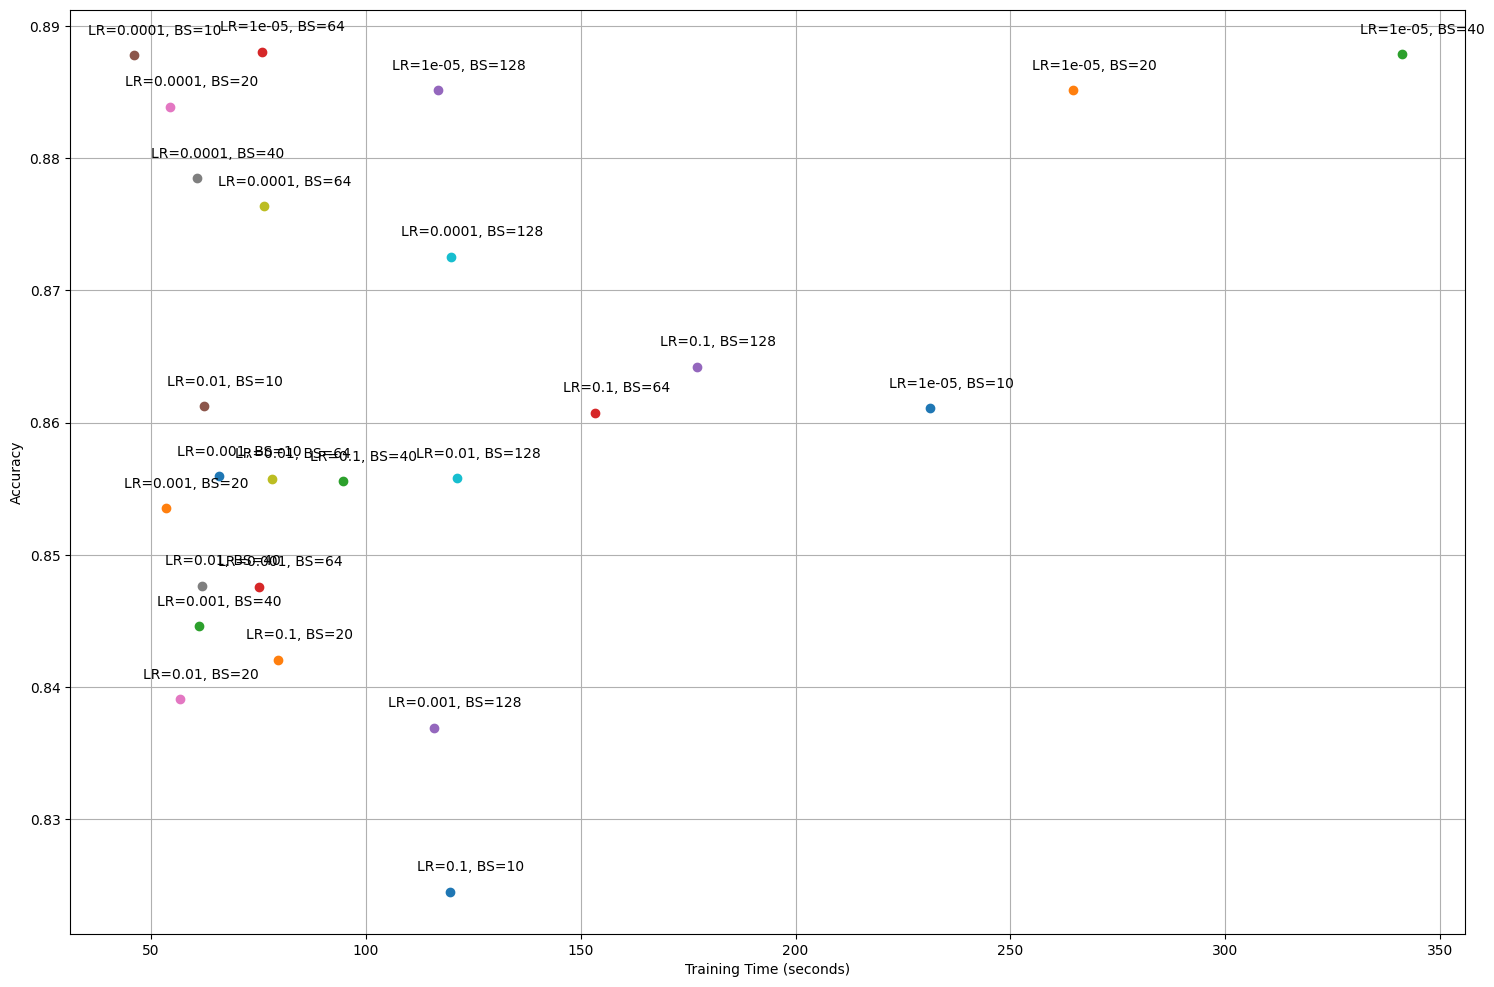

In [24]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
accuracies_by_lr_bs = [[] for _ in range(len(learning_rates))]

for entry in results:
    lr_idx = learning_rates.index(entry["Learning Rate"])
    bs_idx = batch_sizes.index(entry["Batch Size"])
    accuracies_by_lr_bs[lr_idx].append((entry["Training Time"], entry["Accuracy"], entry["Batch Size"]))

plt.figure(figsize=(18, 12))

for lr, acc_list in zip(learning_rates, accuracies_by_lr_bs):
    for training_time, acc, batch_size in acc_list:
        plt.scatter(training_time, acc, label=f'LR={lr}, BS={batch_size}')
        plt.annotate(f'LR={lr}, BS={batch_size}', (training_time, acc), textcoords="offset points", xytext=(15, 15), ha='center')

plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [27]:
import pickle

# Save results dictionary to a file using pickle
with open('results_Ex6.pkl', 'wb') as f:
    pickle.dump(results, f)

# Download the file to your local machine
from google.colab import files
files.download('results_Ex6.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from google.colab import files

# Upload the results.pkl file
uploaded = files.upload()

Saving results_Ex6 (2).pkl to results_Ex6 (2).pkl


In [29]:
import pickle

file_path = 'results_Ex6.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

In [30]:
print(results)

[{'Learning Rate': 1e-05, 'Batch Size': 10, 'Epoch': 8.0, 'Validation Loss': 0.4030337929725647, 'Accuracy': 0.86108, 'Training Time': 231.3968427181244}, {'Learning Rate': 1e-05, 'Batch Size': 20, 'Epoch': 16.0, 'Validation Loss': 0.29519370198249817, 'Accuracy': 0.88512, 'Training Time': 264.62759923934937}, {'Learning Rate': 1e-05, 'Batch Size': 40, 'Epoch': 30.4, 'Validation Loss': 0.27641013264656067, 'Accuracy': 0.88784, 'Training Time': 341.03639960289}, {'Learning Rate': 1e-05, 'Batch Size': 64, 'Epoch': 7.67, 'Validation Loss': 0.2763533294200897, 'Accuracy': 0.88804, 'Training Time': 75.88201689720154}, {'Learning Rate': 1e-05, 'Batch Size': 128, 'Epoch': 15.31, 'Validation Loss': 0.2795080542564392, 'Accuracy': 0.88512, 'Training Time': 116.73450064659119}, {'Learning Rate': 0.0001, 'Batch Size': 10, 'Epoch': 1.4, 'Validation Loss': 0.2861112058162689, 'Accuracy': 0.88776, 'Training Time': 45.988428354263306}, {'Learning Rate': 0.0001, 'Batch Size': 20, 'Epoch': 2.8, 'Valida

Generally, smaller learning rates and smaller batch sizes leads to the higher accuracies.

The training time increases also with the rise of batch sizes.

However, accuracy does not follow the same trend for all cases and it is important to find the appropriate batch size and learning rate to achieve the ebst results in a short time.